
# Tech Challenge — Obesity (Notebook Único)

Este notebook contém **todo o fluxo** do projeto, com comentários didáticos:

1. **Bibliotecas**
2. **Load + Cleaning** (com tratamento de *ruído* conforme o dicionário)
3. **EDA** (visão de dados + visão médica com insights)
4. **Train/Test + Pipeline**
5. **Metrics** (acurácia em % + dicionário)
6. **Save model** (para uso no Streamlit)

> Estrutura esperada do projeto:
> ```
> techchallenge_obesity/
> ├── database/Obesity.csv
> ├── notebooks/01_exploratory_analysis.ipynb
> ├── models/
> └── outputs/
> ```


## 0) Bibliotecas (APENAS IMPORTS)

In [6]:

import os
import json
import joblib
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier


## 1) Load + Cleaning

In [7]:

# Caminho relativo ao notebook (dentro de notebooks/)
DATA_PATH = "../database/Obesity.csv"
print("📌 Lendo:", os.path.abspath(DATA_PATH))

df = pd.read_csv(DATA_PATH)
df.columns = [c.strip() for c in df.columns]

# Padronização comum do dataset
if "TER" in df.columns and "TUE" not in df.columns:
    df = df.rename(columns={"TER": "TUE"})

print("✅ Dataset carregado! Shape:", df.shape)
df.head()


📌 Lendo: /app/techchallenge_obesity/database/Obesity.csv
✅ Dataset carregado! Shape: (2111, 17)


,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


### 1.1 Verificar tipos e nulos

In [8]:

df.info()
df.isna().sum().sort_values(ascending=False).head(20)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          2111 non-null   object 
 1   Age             2111 non-null   float64
 2   Height          2111 non-null   float64
 3   Weight          2111 non-null   float64
 4   family_history  2111 non-null   object 
 5   FAVC            2111 non-null   object 
 6   FCVC            2111 non-null   float64
 7   NCP             2111 non-null   float64
 8   CAEC            2111 non-null   object 
 9   SMOKE           2111 non-null   object 
 10  CH2O            2111 non-null   float64
 11  SCC             2111 non-null   object 
 12  FAF             2111 non-null   float64
 13  TUE             2111 non-null   float64
 14  CALC            2111 non-null   object 
 15  MTRANS          2111 non-null   object 
 16  Obesity         2111 non-null   object 
dtypes: float64(8), object(9)
memory u

Gender            0
SMOKE             0
MTRANS            0
CALC              0
TUE               0
FAF               0
SCC               0
CH2O              0
CAEC              0
Age               0
NCP               0
FCVC              0
FAVC              0
family_history    0
Weight            0
Height            0
Obesity           0
dtype: int64


### 1.2 Ponto Crítico — Tratamento do *ruído* (OBRIGATÓRIO)

Conforme o **dicionário de dados**, as colunas abaixo possuem valores decimais que representam *ruído*
e **devem ser arredondadas e convertidas para inteiro** **ANTES** do treino:

- FCVC (Vegetais)
- NCP (Refeições)
- CH2O (Água)
- FAF (Atividade Física)
- TUE (Tempo em dispositivos)


In [9]:

cols_ruido = ["FCVC", "NCP", "CH2O", "FAF", "TUE"]

for col in cols_ruido:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
        df[col] = df[col].round().astype("Int64")  # inteiro com suporte a NA

print("✅ Ruído tratado (round + int):", [c for c in cols_ruido if c in df.columns])

# Validação rápida
for col in cols_ruido:
    if col in df.columns:
        print(col, "| dtype:", df[col].dtype, "| amostra:", df[col].dropna().unique()[:10])


✅ Ruído tratado (round + int): ['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
FCVC | dtype: Int64 | amostra: <IntegerArray>
[2, 3, 1]
Length: 3, dtype: Int64
NCP | dtype: Int64 | amostra: <IntegerArray>
[3, 1, 4, 2]
Length: 4, dtype: Int64
CH2O | dtype: Int64 | amostra: <IntegerArray>
[2, 3, 1]
Length: 3, dtype: Int64
FAF | dtype: Int64 | amostra: <IntegerArray>
[0, 3, 2, 1]
Length: 4, dtype: Int64
TUE | dtype: Int64 | amostra: <IntegerArray>
[1, 0, 2]
Length: 3, dtype: Int64


### 1.3 Identificar a coluna alvo (target)

In [10]:

possible_targets = ["NObeyesdad", "Obesity", "Obesity_level", "obesity_level"]
target_col = next((c for c in possible_targets if c in df.columns), df.columns[-1])
print("🎯 Target:", target_col)
df[target_col].value_counts()

# Criar a feature BMI (IMC) antes de separar X e y
# Fórmula: Peso (kg) / Altura (m)²
df['BMI'] = df['Weight'] / (df['Height'] ** 2)

print("✅ Feature BMI criada com sucesso!")

🎯 Target: Obesity
✅ Feature BMI criada com sucesso!


### 1.4 Separar X e y

In [11]:

X = df.drop(columns=[target_col])
y = df[target_col].astype(str)

print("X:", X.shape, "| y:", y.shape)
y.value_counts()


X: (2111, 17) | y: (2111,)


Obesity
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: count, dtype: int64

## 2) EDA — Visão de Dados + Visão Médica

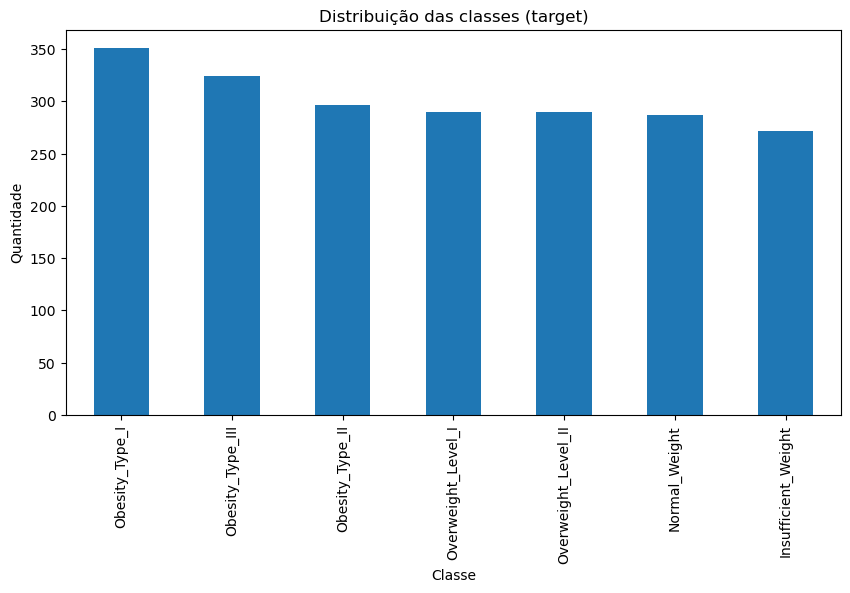

In [12]:

plt.figure(figsize=(10,5))
y.value_counts().plot(kind="bar")
plt.title("Distribuição das classes (target)")
plt.xlabel("Classe")
plt.ylabel("Quantidade")
plt.show()


### 2.1 Separar colunas numéricas e categóricas

In [13]:

numeric_cols = X.select_dtypes(include=["int64", "float64", "Int64"]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

print("Numéricas:", len(numeric_cols), numeric_cols[:10])
print("Categóricas:", len(categorical_cols), categorical_cols[:10])


Numéricas: 9 ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI']
Categóricas: 8 ['Gender', 'family_history', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']


### 2.2 Estatísticas e correlação (numéricas)

In [14]:

X[numeric_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
Age,2111.0,24.3126,6.345968,14.0,19.947192,22.77789,26.0,61.0
Height,2111.0,1.701677,0.093305,1.45,1.63,1.700499,1.768464,1.98
Weight,2111.0,86.586058,26.191172,39.0,65.473343,83.0,107.430682,173.0
FCVC,2111.0,2.423496,0.583905,1.0,2.0,2.0,3.0,3.0
NCP,2111.0,2.687826,0.80968,1.0,3.0,3.0,3.0,4.0
CH2O,2111.0,2.014685,0.688616,1.0,2.0,2.0,2.0,3.0
FAF,2111.0,1.006632,0.895462,0.0,0.0,1.0,2.0,3.0
TUE,2111.0,0.664614,0.674009,0.0,0.0,1.0,1.0,2.0
BMI,2111.0,29.700159,8.011337,12.998685,24.325802,28.719089,36.016501,50.811753


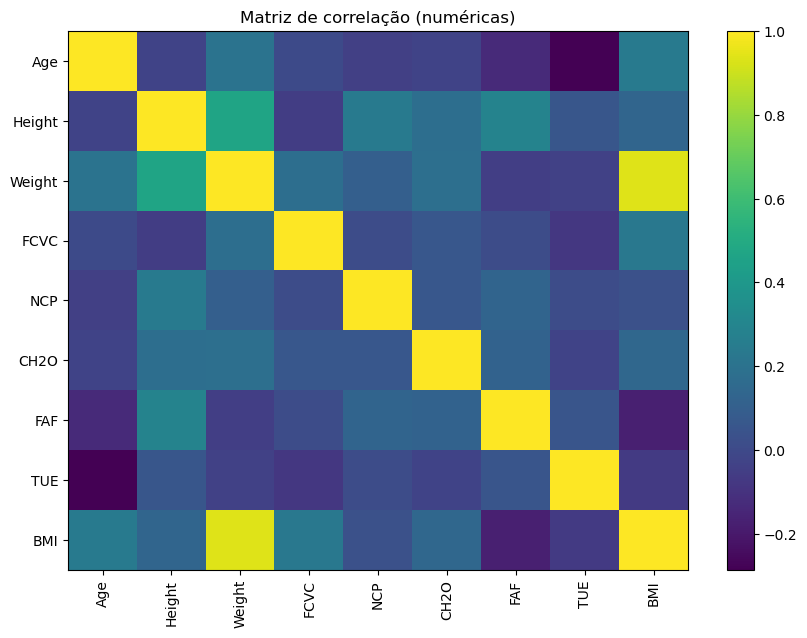

In [15]:

corr = X[numeric_cols].astype(float).corr()

plt.figure(figsize=(10,7))
plt.imshow(corr, aspect="auto")
plt.title("Matriz de correlação (numéricas)")
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.colorbar()
plt.show()


### 2.3 Insights (Visão Médica)

In [16]:

print("🩺 INSIGHTS PARA A EQUIPE MÉDICA\n")
print("• FAF (atividade física) e TUE (tempo em dispositivos) ajudam a identificar perfis sedentários.")
print("  ➜ Ação: priorizar triagem preventiva para FAF baixo e TUE alto.\n")
print("• FCVC (vegetais) e CH2O (água) diferenciam hábitos alimentares.")
print("  ➜ Ação: reforçar orientação nutricional e hidratação.\n")
print("• O modelo é apoio à decisão e NÃO substitui diagnóstico clínico.")


🩺 INSIGHTS PARA A EQUIPE MÉDICA

• FAF (atividade física) e TUE (tempo em dispositivos) ajudam a identificar perfis sedentários.
  ➜ Ação: priorizar triagem preventiva para FAF baixo e TUE alto.

• FCVC (vegetais) e CH2O (água) diferenciam hábitos alimentares.
  ➜ Ação: reforçar orientação nutricional e hidratação.

• O modelo é apoio à decisão e NÃO substitui diagnóstico clínico.


## 3) Train/Test + Pipeline

In [17]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)


Train: (1688, 17) (1688,)
Test: (423, 17) (423,)


In [18]:

numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

model = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)

clf = Pipeline(steps=[("preprocess", preprocess), ("model", model)])
clf


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Height', 'Weight',
                                                   'FCVC', 'NCP', 'CH2O', 'FAF',
                                                   'TUE', 'BMI']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'family_history',
                                                   'FAVC', 'CAEC', 'SMOKE',
                                                   'SCC', 'CALC',
                                                   'MTRANS'])])),
                ('model',
                 RandomForestClassifier(n_estimators=300, n_jobs=-1,
                                        random_state=42))])

In [19]:

clf.fit(X_train, y_train)
print("✅ Treinamento concluído!")


✅ Treinamento concluído!


## 4) Metrics

In [20]:

pred = clf.predict(X_test)
acc = accuracy_score(y_test, pred) * 100

print("📊 RESULTADOS")
print("="*60)
print(f"Acurácia: {acc:.2f}%")
print("="*60)


📊 RESULTADOS
Acurácia: 97.87%


In [21]:

class_description = {
    "Insufficient_Weight": "Peso abaixo do recomendado (baixo peso).",
    "Normal_Weight": "Peso adequado.",
    "Overweight_Level_I": "Sobrepeso nível I.",
    "Overweight_Level_II": "Sobrepeso nível II.",
    "Obesity_Type_I": "Obesidade grau I.",
    "Obesity_Type_II": "Obesidade grau II.",
    "Obesity_Type_III": "Obesidade grau III (severa).",
}

for k, v in class_description.items():
    if k in y.unique():
        print(f"• {k}: {v}")


• Insufficient_Weight: Peso abaixo do recomendado (baixo peso).
• Normal_Weight: Peso adequado.
• Overweight_Level_I: Sobrepeso nível I.
• Overweight_Level_II: Sobrepeso nível II.
• Obesity_Type_I: Obesidade grau I.
• Obesity_Type_II: Obesidade grau II.
• Obesity_Type_III: Obesidade grau III (severa).


In [22]:

print("\n📑 Classification Report:\n")
print(classification_report(y_test, pred))



📑 Classification Report:

                     precision    recall  f1-score   support

Insufficient_Weight       1.00      0.98      0.99        54
      Normal_Weight       0.90      0.97      0.93        58
     Obesity_Type_I       1.00      1.00      1.00        70
    Obesity_Type_II       0.98      1.00      0.99        60
   Obesity_Type_III       1.00      0.98      0.99        65
 Overweight_Level_I       0.96      0.93      0.95        58
Overweight_Level_II       1.00      0.98      0.99        58

           accuracy                           0.98       423
          macro avg       0.98      0.98      0.98       423
       weighted avg       0.98      0.98      0.98       423



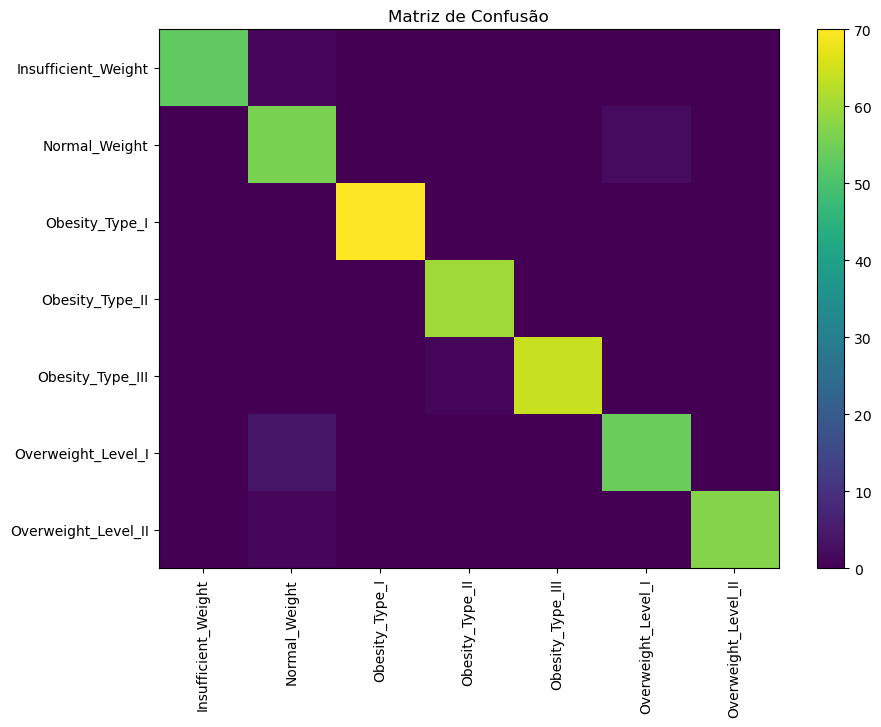

In [23]:

labels = sorted(y.unique().tolist())
cm = confusion_matrix(y_test, pred, labels=labels)

plt.figure(figsize=(10,7))
plt.imshow(cm, aspect="auto")
plt.title("Matriz de Confusão")
plt.xticks(range(len(labels)), labels, rotation=90)
plt.yticks(range(len(labels)), labels)
plt.colorbar()
plt.show()


### 4.1 Salvar métricas para o Streamlit

In [24]:

os.makedirs("../outputs", exist_ok=True)
metrics_payload = {
    "accuracy": float(accuracy_score(y_test, pred)),
    "accuracy_percent": float(acc),
    "target_col": target_col,
    "classes": labels,
}

with open("../outputs/metrics.json", "w") as f:
    json.dump(metrics_payload, f, indent=2)

print("✅ Métricas salvas em ../outputs/metrics.json")
metrics_payload


✅ Métricas salvas em ../outputs/metrics.json


{'accuracy': 0.9787234042553191,
 'accuracy_percent': 97.87234042553192,
 'target_col': 'Obesity',
 'classes': ['Insufficient_Weight',
  'Normal_Weight',
  'Obesity_Type_I',
  'Obesity_Type_II',
  'Obesity_Type_III',
  'Overweight_Level_I',
  'Overweight_Level_II']}

## 5) Save model ✅

In [25]:

os.makedirs("../models", exist_ok=True)

joblib.dump(clf, "../models/obesity_pipeline.joblib")

with open("../models/feature_columns.json", "w") as f:
    json.dump(X.columns.tolist(), f, indent=2)

with open("../models/target_classes.json", "w") as f:
    json.dump(labels, f, indent=2)

print("✅ Modelo e metadados salvos em ../models/")


✅ Modelo e metadados salvos em ../models/


In [26]:

# Teste rápido de carga do modelo
clf_loaded = joblib.load("../models/obesity_pipeline.joblib")
sample = X_test.iloc[[0]].copy()
print("Predição (modelo carregado):", clf_loaded.predict(sample)[0])
print("Real:", y_test.iloc[0])


Predição (modelo carregado): Insufficient_Weight
Real: Insufficient_Weight
